In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.feature_selection import mutual_info_classif
import seaborn as sns
from matplotlib import pyplot as plt
from joblib import Parallel, delayed
%matplotlib inline
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)

In [2]:
def bounded_sample(kde, sample_size, lower_bound, upper_bound):
    samp = np.round(kde.resample(size=sample_size))
    samp = samp[(samp >= lower_bound) & (samp <= upper_bound)]
    while len(samp) < sample_size:
        topup = np.round(kde.resample(size=sample_size - len(samp)))
        topup = topup[(topup >= lower_bound) & (topup <= upper_bound)]
        samp = np.hstack([samp, topup])
    return samp

def create_population(dat, pop_size, target_indicator="moodanxiety_bothered", baars_max=54, hitop_max=219):
    # create population 
    baars_may_kde = stats.gaussian_kde(dat.query(f"{target_indicator}").baars_sum)
    baars_man_kde = stats.gaussian_kde(dat.query(f"~{target_indicator}").baars_sum)
    
    hitop_may_kde = stats.gaussian_kde(dat.query(f"{target_indicator}").hitop_sum)
    hitop_man_kde = stats.gaussian_kde(dat.query(f"~{target_indicator}").hitop_sum)
    
    baars_may_pop = bounded_sample(baars_may_kde, pop_size, 0, baars_max)
    baars_man_pop = bounded_sample(baars_man_kde, pop_size, 0, baars_max)
    hitop_may_pop = bounded_sample(hitop_may_kde, pop_size, 0, hitop_max)
    hitop_man_pop = bounded_sample(hitop_man_kde, pop_size, 0, hitop_max)
    
    hitop_pop = np.hstack([hitop_may_pop, hitop_man_pop])
    baars_pop = np.hstack([baars_may_pop, baars_man_pop])
    ma_pop = np.hstack([np.ones(pop_size), np.zeros(pop_size)])
    
    pop = pd.DataFrame(data=np.array([baars_pop, hitop_pop, ma_pop.astype(bool)]).T, columns=['baars_sum', 'hitop_sum', target_indicator])
    pop[target_indicator] = pop[target_indicator].astype(bool)
    return pop

def run_sim(k, subsamp_nbins, ssn, pop, target, perms, subsamp_size, nperms, random_state):
    subsamp = pd.concat([pop.query(target).sample(n=subsamp_size, random_state=random_state, replace=False),
                         pop.query(f'~{target}').sample(n=subsamp_size, random_state=random_state, replace=False)])
    # WATCH OUT FOR THIS, I'm only doing this because I'm copying pop when creating the job
    del pop
    subsamp['baars_bi n'] = pd.cut(subsamp.baars_sum, subsamp_nbins, labels=False)
    subsamp['hitop_bin'] = pd.cut(subsamp.hitop_sum, subsamp_nbins, labels=False)
    tmp = mutual_info_classif(subsamp.loc[:, ['baars_sum', 'baars_bin', 'hitop_sum' ,'hitop_bin']],
                    subsamp[target],
                    discrete_features=[False, True, False, True], n_neighbors=k)

    perm_res = []
    for permn in range(nperms):
        perm_tmp = mutual_info_classif(subsamp.loc[:, ['baars_sum', 'baars_bin', 'hitop_sum' ,'hitop_bin']],
                                subsamp[target].iloc[perms[permn]].values,
                                discrete_features=[False, True, False, True], n_neighbors=k)
        perm_nn = perm_tmp[0] - perm_tmp[2]
        perm_bin = perm_tmp[1] - perm_tmp[3]
        perm_res.append([perm_nn, perm_bin])
    perm_res = np.array(perm_res)
    perm_limits = np.quantile(perm_res, [0.025, 0.975], axis=0)
    
    row = dict(
        target=target,
        subsamp_size=subsamp_size,
        subsamp_nbins=subsamp_nbins,
        k=k,
        ssn=ssn,
        baars_nn=tmp[0],
        baars_bin=tmp[1],
        hitop_nn=tmp[2],
        hitop_bin=tmp[3],
        hitop_wins_nn = (tmp[0] - tmp[2]) < perm_limits[0][0],
        baars_wins_nn = (tmp[0] - tmp[2]) > perm_limits[1][0],
        hitop_wins_bin = (tmp[1] - tmp[3]) < perm_limits[0][1],
        baars_wins_bin = (tmp[1] - tmp[3]) > perm_limits[1][1]
    )
    return row

In [3]:
dat = pd.read_csv('../data/mitest_data.csv')
targets = ['moodanxiety_bothered', 'mood_bothered', 'anxiety_bothered']


In [4]:
# look at sample overlaps for the three indicators
dat.groupby(targets)[['hitop_sum']].count()

hitop_sum
moodanxiety_bothered mood_bothered anxiety_bothered           
False                False         False                    12
True                 False         True                      3
                     True          False                     1
                                   True                      5

In [5]:
baars_max = 18 * 3
hitop_max = 73 * 3
pop_size = 100000
nperms = 500
subsamp_size = 250 # this is actually half the subsample size
nsims = 100 # number of simulations per setting

# define values to test over
ks = np.arange(1, 11).astype(int)
nbins = (np.arange(1, 11) / 5 *  np.round(np.sqrt(2 * subsamp_size))).astype(int)

# initialize rng and random states
perms = np.array([pd.DataFrame(np.arange(2 * subsamp_size)).sample(frac=1, replace=False).values for n in range(nperms+1)]).squeeze()
rng = np.random.default_rng(12331948714351098341)
random_states = rng.integers(0, 10000000, 10000)

In [6]:
pops = {}
for target in targets:
    pops[target] = create_population(dat, pop_size, target_indicator=target)

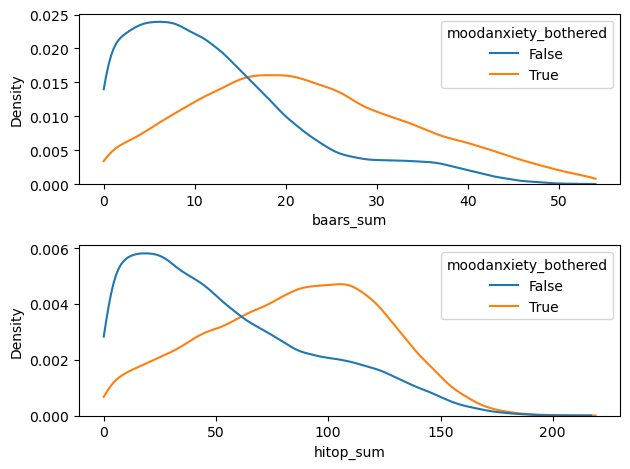

In [7]:
target = "moodanxiety_bothered"
fig, axes = plt.subplots(2)
sns.kdeplot(data=pops[target], x="baars_sum", hue=target, cut=0, ax=axes[0])
sns.kdeplot(data=pops[target], x="hitop_sum", hue=target, cut=0, ax=axes[1])
fig.tight_layout()

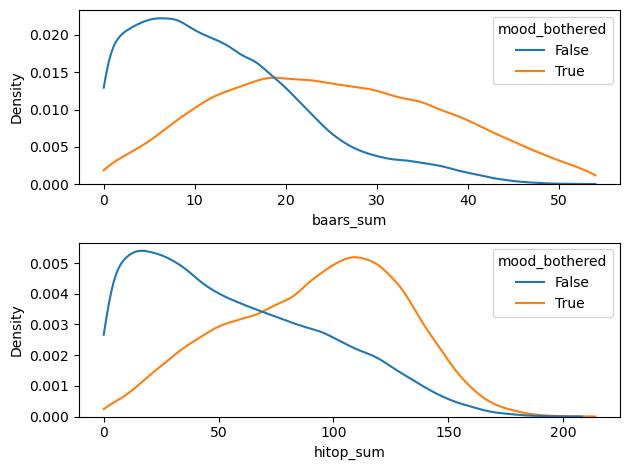

In [8]:
target = "mood_bothered"
fig, axes = plt.subplots(2)
sns.kdeplot(data=pops[target], x="baars_sum", hue=target, cut=0, ax=axes[0])
sns.kdeplot(data=pops[target], x="hitop_sum", hue=target, cut=0, ax=axes[1])
fig.tight_layout()

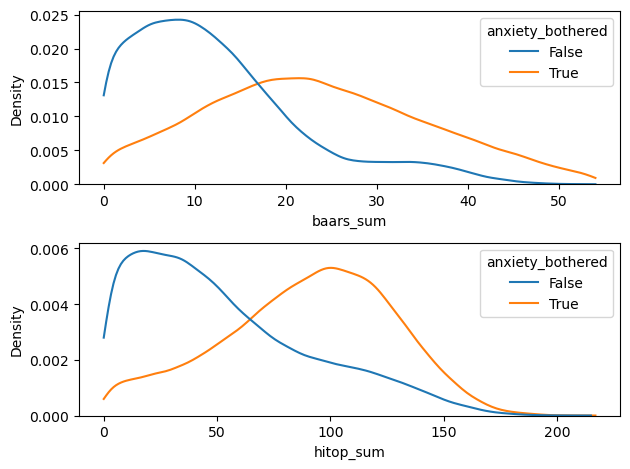

In [9]:
target = "anxiety_bothered"
fig, axes = plt.subplots(2)
sns.kdeplot(data=pops[target], x="baars_sum", hue=target, cut=0, ax=axes[0])
sns.kdeplot(data=pops[target], x="hitop_sum", hue=target, cut=0, ax=axes[1])
fig.tight_layout()

In [10]:
# calculate MI for each target
nbin = int(np.round(np.sqrt(pop_size * 2)))
k = 3
popres = []
# If you want permutation results at the population level, set permute to true. It's pretty slow though.
permute = False
rsix = [0]
for target in targets:
    pop = pops[target]
    pop['baars_bin'] = pd.cut(pop.baars_sum, nbin, labels=False)
    pop['hitop_bin'] = pd.cut(pop.hitop_sum, nbin, labels=False)

    tmp = mutual_info_classif(pop.loc[:, ['baars_sum', 'baars_bin', 'hitop_sum' ,'hitop_bin']],
                    pop[target],
                    discrete_features=[False, True, False, True])
    if permute:
        perm_res = []
        for permn in range(nperms):
            perm_tmp = mutual_info_classif(pop.loc[:, ['baars_sum', 'baars_bin', 'hitop_sum' ,'hitop_bin']],
                                    pop[target].sample(frac=1, replace=False, random_state=random_states[rsix]).values,
                                    discrete_features=[False, True, False, True], n_neighbors=k)
            perm_nn = perm_tmp[0] - perm_tmp[2]
            perm_bin = perm_tmp[1] - perm_tmp[3]
            perm_res.append([perm_nn, perm_bin])
        perm_res = np.array(perm_res)
        perm_limits = np.quantile(perm_res, [0.025, 0.975], axis=0)
        hitop_wins_nn = (tmp[0] - tmp[2]) < perm_limits[0][0]
        baars_wins_nn = (tmp[0] - tmp[2]) > perm_limits[1][0]
        hitop_wins_bin = (tmp[1] - tmp[3]) < perm_limits[0][1]
        baars_wins_bin = (tmp[1] - tmp[3]) > perm_limits[1][1]
        row = dict(
            target=target,
            baars_nn=tmp[0],
            baars_bin=tmp[1],
            hitop_nn=tmp[2],
            hitop_bin=tmp[3],
            hitop_wins_nn = (tmp[0] - tmp[2]) < perm_limits[0][0],
            baars_wins_nn = (tmp[0] - tmp[2]) > perm_limits[1][0],
            hitop_wins_bin = (tmp[1] - tmp[3]) < perm_limits[0][1],
            baars_wins_bin = (tmp[1] - tmp[3]) > perm_limits[1][1]
        )
    else:
        row = dict(
            target=target,
            baars_nn=tmp[0],
            baars_bin=tmp[1],
            hitop_nn=tmp[2],
            hitop_bin=tmp[3]
        )
    popres.append(row)
popres = pd.DataFrame(popres)

In [11]:
popres

,target,baars_nn,baars_bin,hitop_nn,hitop_bin
0,moodanxiety_bothered,0.089890,0.090917,0.072135,0.073130
1,mood_bothered,0.124953,0.126019,0.093051,0.094098
2,anxiety_bothered,0.116744,0.116555,0.108233,0.110079


In [12]:
# sequential processing
# ks = np.arange(1, 11).astype(int)
# nbins = (np.arange(1, 11) / 5 *  np.round(np.sqrt(2 * subsamp_size))).astype(int)
# res = []
# #for k, subsamp_nbins in zip(ks, nbins):
# k = 3
# subsamp_nbins = 22
# rsix = 0
# for ssn in range(n_subsamps):
#         subsamp = pd.concat([samp.query('moodanxiety_bothered').sample(n=subsamp_size, replace=False, random_state=random_states[rsix]),
#                              samp.query('~moodanxiety_bothered').sample(n=subsamp_size, replace=False, random_state=random_states[rsix])])
#         subsamp['baars_bin'] = pd.cut(subsamp.baars_sum, subsamp_nbins, labels=False)
#         subsamp['hitop_bin'] = pd.cut(subsamp.hitop_sum, subsamp_nbins, labels=False)
#         tmp = mutual_info_classif(subsamp.loc[:, ['baars_sum', 'baars_bin', 'hitop_sum' ,'hitop_bin']],
#                         subsamp.moodanxiety_bothered,
#                         discrete_features=[False, True, False, True], n_neighbors=k)

#         perm_res = []
#         for permn in range(nperms):
#             perm_tmp = mutual_info_classif(subsamp.loc[:, ['baars_sum', 'baars_bin', 'hitop_sum' ,'hitop_bin']],
#                                     subsamp.moodanxiety_bothered.iloc[perms[permn]].values,
#                                     discrete_features=[False, True, False, True], n_neighbors=k)
#             perm_nn = perm_tmp[0] - perm_tmp[2]
#             perm_bin = perm_tmp[1] - perm_tmp[3]
#             perm_res.append([perm_nn, perm_bin])
#         perm_res = np.array(perm_res)
#         perm_limits = np.quantile(perm_res, [0.025, 0.975], axis=0)
        

#         row = dict(
#             subsamp_size=subsamp_size,
#             subsamp_nbins=subsamp_nbins,
#             k=k,
#             ssn=ssn,
#             baars_nn=tmp[0],
#             baars_bin=tmp[1],
#             hitop_nn=tmp[2],
#             hitop_bin=tmp[3],
#             hitop_wins_nn = (tmp[0] - tmp[2]) < perm_limits[0][0],
#             baars_wins_nn = (tmp[0] - tmp[2]) > perm_limits[1][0],
#             hitop_wins_bin = (tmp[1] - tmp[3]) < perm_limits[0][1],
#             baars_wins_bin = (tmp[1] - tmp[3]) > perm_limits[1][1]
#         )
#         res.append(row)
#         rsix += 1
# res = pd.DataFrame(res)


In [13]:
# parallel processing
jobs = []
for target in targets:
    rsix = 0
    for k, subsamp_nbins in zip(ks, nbins):
        for ssn in range(nsims):
            jobs.append(delayed(run_sim)(k, subsamp_nbins, ssn, pops[target].copy(), target, perms.copy(), subsamp_size, nperms, random_states[rsix]))
            rsix += 1

In [14]:
pres = Parallel(n_jobs=1, verbose=10)(jobs)

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    4.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:   15.5s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:   26.9s
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:   45.9s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:  1.1min
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:  1.5min
[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:  2.0min
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  2.6min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  3.2min
[Parallel(n_jobs=1)]: Done  60 tasks      | elapsed:  4.0min
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:  4.8min
[Parallel(n_jobs=1)]: Done  84 tasks      | elapsed:  5.6min
[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:  6.4min
[Parallel(n_jobs=1)]: Done 112 tasks      | elapsed:  7.5min
[Parallel(n_jobs=1)]: Done 127 tasks      | elapsed:  8.5min
[Parallel(n_jobs=1)]: Done 144 tasks      | elapsed:  9.7min
[Parallel(n_jobs=1)]: Do

In [15]:
pres = pd.DataFrame(pres)

In [17]:
pres.to_csv("../data/pres.csv", index=None)

In [18]:
pres.groupby(['target', 'subsamp_nbins', 'k'])[['hitop_wins_nn', 'baars_wins_nn', 'hitop_wins_bin', 'baars_wins_bin']].mean()

hitop_wins_nn  baars_wins_nn  \
target               subsamp_nbins k                                  
anxiety_bothered     4             1            0.10           0.10   
                     8             2            0.09           0.16   
                     13            3            0.09           0.29   
                     17            4            0.10           0.26   
                     22            5            0.06           0.25   
                     26            6            0.08           0.21   
                     30            7            0.18           0.27   
                     35            8            0.16           0.29   
                     39            9            0.15           0.28   
                     44            10           0.12           0.29   
mood_bothered        4             1            0.06           0.29   
                     8             2            0.02           0.41   
                     13            3            0.04           0.34   
                     17            4            0.07           0.42   
                     22            5            0.02           0.47   
                     26            6            0.01           0.60   
                     30            7            0.04           0.61   
                     35            8            0.05           0.50   
                     39            9            0.03           0.64   
                     44            10           0.03           0.56   
moodanxiety_bothered 4             1            0.01           0.22   
                     8             2            0.02           0.24   
                     13            3            0.04           0.20   
                     17            4            0.05           0.26   
                     22            5            0.08           0.32   
                     26            6            0.06           0.37   
                     30            7            0.04           0.42   
                     35            8            0.05           0.36   
                     39            9            0.06           0.33   
                     44            10           0.10           0.41   

                                       hitop_wins_bin  baars_wins_bin  
target               subsamp_nbins k                                   
anxiety_bothered     4             1             0.11            0.36  
                     8             2             0.21            0.28  
                     13            3             0.20            0.24  
                     17            4             0.23            0.22  
                     22            5             0.16            0.25  
                     26            6             0.22            0.18  
                     30            7             0.17            0.20  
                     35            8             0.20            0.23  
                     39            9             0.26            0.24  
                     44            10            0.16            0.13  
mood_bothered        4             1             0.00            0.68  
                     8             2             0.03            0.59  
                     13            3             0.04            0.53  
                     17            4             0.09            0.47  
                     22            5             0.04            0.52  
                     26            6             0.00            0.55  
                     30            7             0.06            0.55  
                     35            8             0.03            0.45  
                     39            9             0.01            0.48  
                     44            10            0.04            0.39  
moodanxiety_bothered 4             1             0.08            0.52  
                     8             2             0.04            0.34  
                     13            3  

[0.12258977 0.0098948 ]


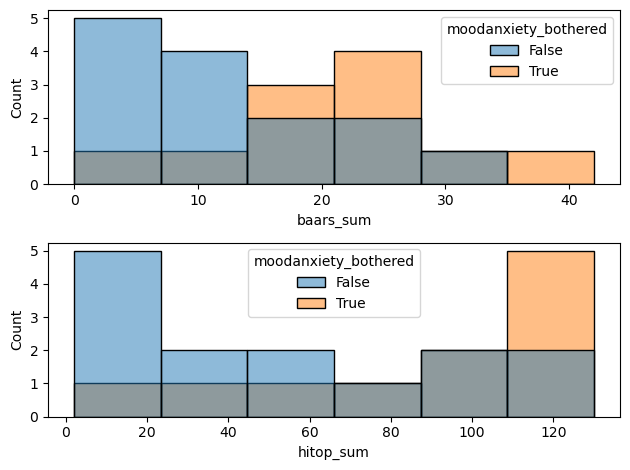

In [46]:
print(mutual_info_classif(dat.loc[:, ['baars_sum', 'hitop_sum']], dat.moodanxiety_bothered, discrete_features=False))
fig, axes = plt.subplots(2)
sns.histplot(data=dat, x='baars_sum', hue='moodanxiety_bothered', ax=axes[0])
sns.histplot(data=dat, x='hitop_sum', hue='moodanxiety_bothered', ax=axes[1])
fig.tight_layout()

[0.08508065 0.52837025]


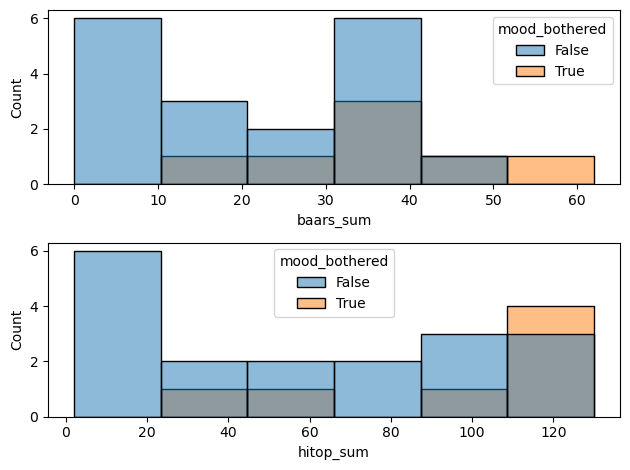

In [233]:

print(mutual_info_classif(dat.loc[:, ['baars_sum', 'hitop_sum']], dat.mood_bothered, discrete_features=False))

fig, axes = plt.subplots(2)
sns.histplot(data=dat, x='baars_sum', hue='mood_bothered', ax=axes[0])
sns.histplot(data=dat, x='hitop_sum', hue='mood_bothered', ax=axes[1])
fig.tight_layout()

In [219]:
mutual_info_classif(dat.loc[:, ['baars_sum', 'hitop_sum']], dat.anxiety_bothered, discrete_features=False)

array([0.2537547 , 0.08910314])

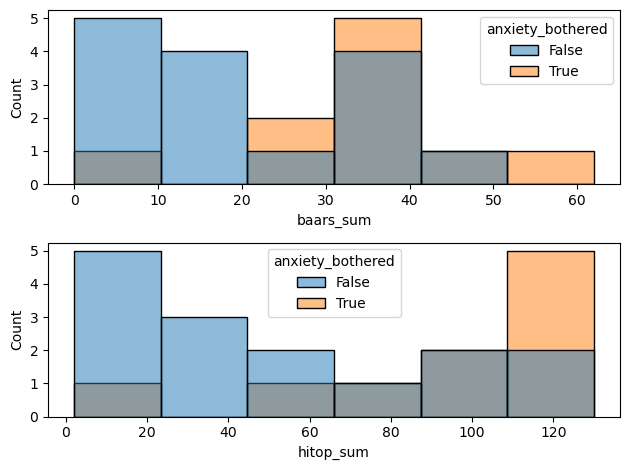

In [232]:
fig, axes = plt.subplots(2)
sns.histplot(data=dat, x='baars_sum', hue='anxiety_bothered', ax=axes[0])
sns.histplot(data=dat, x='hitop_sum', hue='anxiety_bothered', ax=axes[1])
fig.tight_layout()

In [220]:
mutual_info_classif(dat.loc[:, ['baars_sum', 'hitop_sum']], dat.attention_bothered, discrete_features=False)

array([0.07148552, 0.01092682])

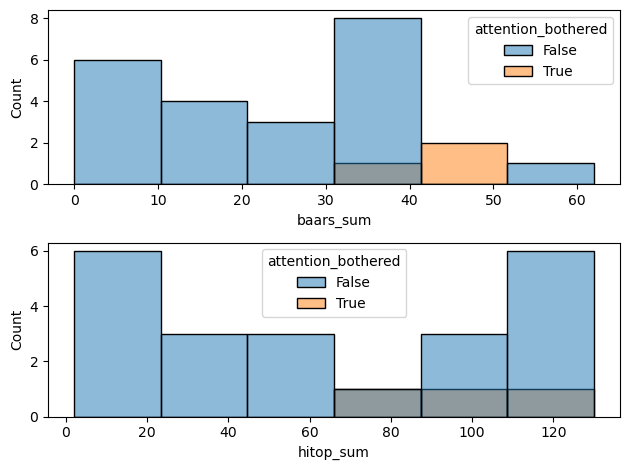

In [231]:
fig, axes = plt.subplots(2)
sns.histplot(data=dat, x='baars_sum', hue='attention_bothered', ax=axes[0])
sns.histplot(data=dat, x='hitop_sum', hue='attention_bothered', ax=axes[1])
fig.tight_layout()

<Axes: xlabel='hitop_sum', ylabel='Count'>

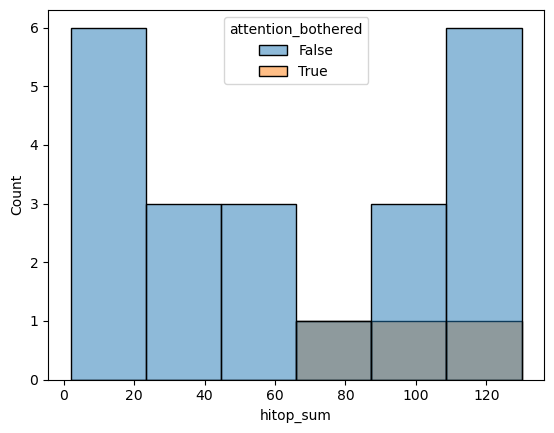

In [226]:
sns.histplot(data=dat, x='hitop_sum', hue='attention_bothered')